# Імпорт бібліотек

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.8 MB/s eta 0:00:00


In [2]:
! pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 28.4 MB/s eta 0:00:00


In [ ]:
#!yolo settings

In [3]:
from ultralytics import settings

settings.update({"datasets_dir": "/content", "wandb": False})

print(settings)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


In [4]:
import os
os.environ['WANDB_MODE'] = 'disabled'

In [5]:
!wandb disabled

W&B disabled.


In [7]:
import zipfile
with zipfile.ZipFile('archive (13).zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [8]:
import yaml
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

import cv2

from ultralytics import YOLO

%matplotlib inline



import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Конфігурація моделі

In [31]:
class CFG:
    DEBUG = np.False_ # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0 # Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
    SEED = 42

    # classes
    CLASSES = ['door', 'cabinetDoor', 'refrigeratorDoor',
               'window', 'chair', 'table', 'cabinet',
               'couch', 'openedDoor', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 8 # 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
    WEIGHT_DECAY = 5e-4 # L2 regularization term, penalizing large weights to prevent overfitting.
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/'
    OUTPUT_DIR = '/content/'

# Підготовка конфігурації датасету

In [32]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [33]:
# read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

# print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /content/test
train: /content/train
val: /content/valid



# Допоміжні функції

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (747, 1024, 3) \n


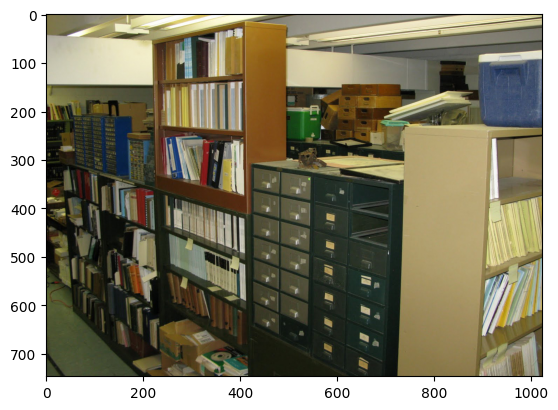

In [34]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\\n')
        print('Shape: ', np.array(img).shape, '\\n')

    if hide_axis:
        plt.axis('off')

    plt.show()


example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/0f238c501cc1f25b.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [35]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

  random.seed(seed)

  # Get a list of image files in the folder
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

  # Ensure that we have at least num_images files to choose from
  if len(image_files) < num_images:
    raise ValueError("Not enough images in the folder")

  # Randomly select num_images image files
  selected_files = random.sample(image_files, num_images)

  # Create a subplot grid
  num_cols = 5
  num_rows = (num_images + num_cols - 1) // num_cols
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

  for i, file_name in enumerate(selected_files):
    # Open and display the image using PIL
    img = Image.open(os.path.join(folder_path, file_name))

    if num_rows == 1:
      ax = axes[i % num_cols]
    else:
      ax = axes[i // num_cols, i % num_cols]

    ax.imshow(img)
    ax.axis('off')
    # ax.set_title(file_name)

  # Remove empty subplots
  for i in range(num_images, num_rows * num_cols):
    if num_rows == 1:
      fig.delaxes(axes[i % num_cols])
    else:
      fig.delaxes(axes[i // num_cols, i % num_cols])

  plt.tight_layout()
  plt.show()

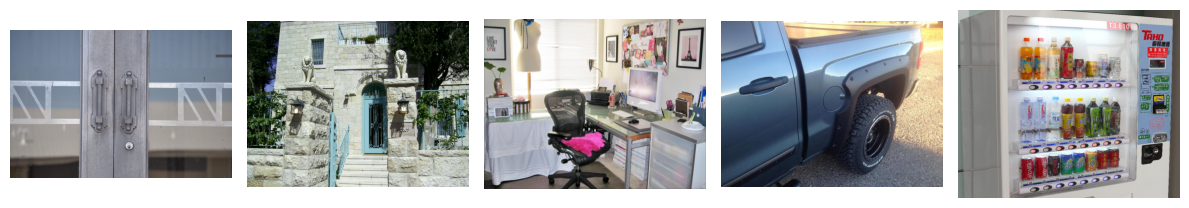

In [14]:
plot_random_images_from_folder(CFG.CUSTOM_DATASET_DIR + 'train/images/', 5)

In [15]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 747, 'channels': 3, 'dtype': dtype('uint8')}

# Дослідження класів

In [16]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


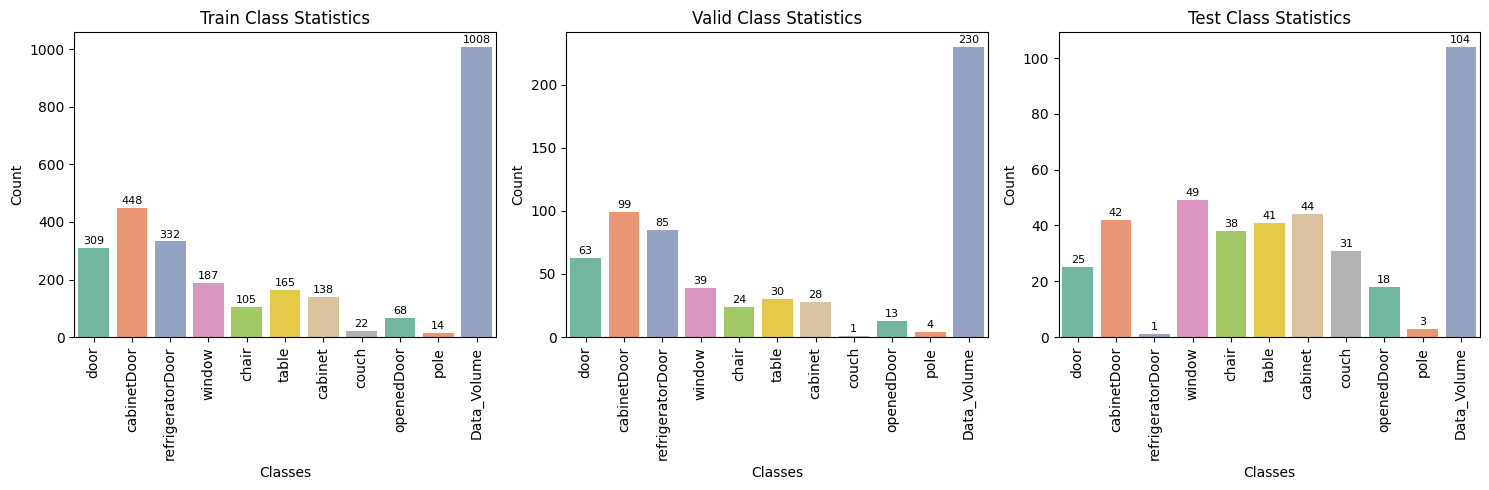

In [17]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

# Тестування моделі без тренування


WARNING ⚠️ imgsz=[747, 1024] must be multiple of max stride 32, updating to [768, 1024]
image 1/1 /content/train/images/0f238c501cc1f25b.jpg: 768x1024 (no detections), 28.7ms
Speed: 3.3ms preprocess, 28.7ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict
0 label saved to runs/detect/predict/labels
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (747, 1024, 3) \n


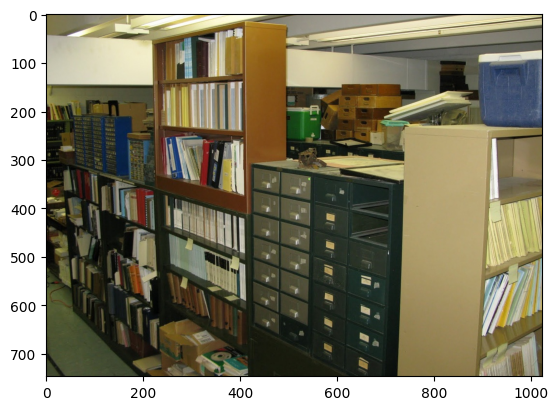

In [36]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,
    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = [0],
    #device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [37]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  8


# Тренування моделі

In [38]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [39]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0], #  [0,1]
    # device = None, # CPU run
    verbose = False,
)

Ultralytics 8.3.17 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/content/data.yaml, epochs=70, time=None, patience=20, batch=8, imgsz=(747, 1024), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:00<00:00, 1229.69it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      25.2G      1.652      2.851       1.75         49       1024: 100%|██████████| 127/127 [01:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]

                   all        230       1289      0.229       0.14      0.105     0.0561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      28.2G      1.618       2.25      1.733         23       1024: 100%|██████████| 127/127 [01:03<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]

                   all        230       1289      0.503      0.132     0.0838     0.0419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      28.2G      1.659      2.326      1.772         43       1024: 100%|██████████| 127/127 [01:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

                   all        230       1289      0.136      0.176     0.0326     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      28.2G      1.656      2.239      1.772         72       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

                   all        230       1289      0.614      0.126      0.095     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      24.9G      1.624      2.152      1.738         52       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]

                   all        230       1289      0.431      0.176      0.117     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      28.1G       1.59      2.117       1.72         20       1024: 100%|██████████| 127/127 [01:02<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

                   all        230       1289      0.478      0.194      0.159     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      28.2G      1.544      1.966      1.694         26       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

                   all        230       1289      0.505      0.195      0.173     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      28.2G      1.527      1.978      1.688         40       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

                   all        230       1289       0.51      0.242      0.191      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      28.2G      1.512       1.92      1.659         20       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

                   all        230       1289      0.557      0.208        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      28.2G      1.494      1.838      1.633         37       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

                   all        230       1289      0.502      0.182      0.188      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      24.9G      1.484      1.829      1.646         67       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

                   all        230       1289      0.502      0.248      0.193      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      24.9G      1.465      1.763      1.622         26       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

                   all        230       1289       0.53      0.263      0.227      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      28.2G      1.459       1.74      1.638         55       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

                   all        230       1289      0.559      0.286       0.24      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      24.9G       1.43      1.703      1.604         21       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289       0.45      0.229      0.219      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      28.2G      1.432       1.65      1.595         25       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]

                   all        230       1289      0.614      0.226      0.248      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      28.2G      1.426      1.652      1.593         29       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

                   all        230       1289       0.56      0.286      0.257       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      28.2G      1.398      1.551      1.545         25       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

                   all        230       1289       0.45      0.269      0.246      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70        25G      1.373      1.537       1.55         41       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

                   all        230       1289      0.563        0.3      0.298      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      28.5G      1.376      1.464      1.543         46       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

                   all        230       1289      0.413      0.274      0.282      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70        25G      1.347      1.466      1.534         16       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]

                   all        230       1289      0.564       0.25      0.262      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70        25G      1.367      1.476      1.544         42       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.557       0.27      0.253      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      28.1G      1.353      1.409      1.514         29       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]

                   all        230       1289      0.474      0.326      0.299      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      28.2G      1.311       1.39      1.518         38       1024: 100%|██████████| 127/127 [01:02<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

                   all        230       1289      0.449      0.302      0.292      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      28.2G      1.316      1.387      1.515         30       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]

                   all        230       1289      0.677      0.299       0.29      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      28.1G      1.314      1.369      1.522         37       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

                   all        230       1289      0.386      0.342      0.303       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70        25G      1.305      1.335      1.508         23       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]

                   all        230       1289      0.505      0.294      0.291      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      28.2G      1.293      1.291      1.494         31       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.614      0.304      0.294      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      28.2G      1.283      1.255      1.474         21       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.672      0.251      0.281      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      24.9G      1.299      1.316      1.492         19       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]

                   all        230       1289      0.439      0.306      0.307      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      28.1G      1.246      1.194      1.467         40       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.679      0.286      0.316      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      28.2G      1.254      1.167      1.437         23       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.529      0.309      0.315      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      28.2G      1.234      1.148      1.453         65       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]

                   all        230       1289      0.455      0.308      0.323      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      28.2G       1.23      1.142      1.434         21       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

                   all        230       1289       0.49      0.332      0.328       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      28.2G      1.225      1.148      1.443         32       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289      0.693      0.306       0.34      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      24.9G      1.199      1.108      1.423         48       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]

                   all        230       1289      0.458      0.318      0.332      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      28.2G      1.197      1.099      1.419         40       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

                   all        230       1289      0.416      0.353      0.336      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70        25G      1.213      1.091       1.43         44       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.589      0.292      0.364      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      24.9G      1.178      1.066      1.413         48       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.586      0.298      0.331      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      28.2G      1.158      1.033      1.403         37       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]

                   all        230       1289      0.469       0.33       0.34      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      28.2G      1.157      1.001        1.4         33       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.552      0.332      0.348       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      28.1G      1.151     0.9883      1.388         20       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289       0.37        0.4      0.349      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      28.2G      1.157      1.004      1.392         51       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

                   all        230       1289      0.548      0.382      0.378      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      28.2G      1.134     0.9734      1.382         32       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289      0.524      0.352      0.348      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      28.2G      1.128     0.9465      1.368         34       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289      0.323      0.564      0.377       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      28.2G      1.105     0.9382      1.368         56       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.482      0.422      0.386      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      24.9G      1.102     0.9091       1.35         26       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289      0.457      0.372      0.362       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      28.2G       1.09      0.901      1.344         40       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.505      0.324       0.36      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      28.2G      1.057     0.8591      1.319         13       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]

                   all        230       1289      0.383      0.357      0.347      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      28.1G      1.062     0.8666      1.329         36       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.564      0.408      0.399      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      24.9G      1.035     0.8345      1.304         52       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.401       0.39      0.373      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      28.2G       1.03     0.8242      1.309         35       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]

                   all        230       1289      0.446      0.345      0.353      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      28.2G      1.036     0.8204      1.306         31       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.433      0.384      0.361       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      24.9G      1.018     0.8232      1.302         20       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289       0.45      0.386      0.368      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      28.1G      1.018     0.7719      1.289         50       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.388      0.514       0.39      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      28.2G      0.991     0.7596      1.284         41       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]

                   all        230       1289       0.46      0.342      0.361      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      28.2G     0.9938     0.7534      1.266         42       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]

                   all        230       1289      0.417      0.453      0.373      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      28.2G     0.9833     0.7486      1.274          7       1024: 100%|██████████| 127/127 [01:02<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289       0.39      0.381      0.356      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      24.9G     0.9424     0.7357      1.253         22       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.386      0.485      0.383      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      24.9G     0.9358     0.6954      1.246         37       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.362      0.392      0.366      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      24.9G     0.9356     0.6931      1.247         27       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

                   all        230       1289      0.541      0.436      0.414      0.259


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70        25G     0.9347     0.6455      1.243         26       1024: 100%|██████████| 127/127 [01:02<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

                   all        230       1289      0.399      0.479      0.371      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      28.2G     0.9036     0.5895      1.222         15       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]

                   all        230       1289      0.404      0.415      0.374      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      28.2G     0.8927     0.5684      1.207         31       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289      0.459      0.469      0.385      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      28.2G     0.8656     0.5475      1.197          6       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]

                   all        230       1289      0.421      0.376       0.37      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      28.1G      0.864     0.5451      1.186         11       1024: 100%|██████████| 127/127 [01:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

                   all        230       1289      0.406      0.409      0.369      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      28.2G     0.8587      0.525      1.193         10       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

                   all        230       1289      0.409       0.53      0.391      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      28.2G     0.8303     0.5168      1.162         22       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.398      0.396      0.372      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70        25G     0.8327     0.5186      1.177         69       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]

                   all        230       1289      0.446      0.353      0.357      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      28.2G     0.8227     0.5033      1.165         27       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]

                   all        230       1289      0.396      0.392      0.365      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      24.9G     0.8077     0.4946      1.161         12       1024: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

                   all        230       1289      0.418      0.369      0.365       0.22



70 epochs completed in 1.349 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics 8.3.17 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


                   all        230       1289       0.54      0.436       0.42      0.263
Speed: 0.3ms preprocess, 17.6ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs
CPU times: user 1h 9min 22s, sys: 15min 6s, total: 1h 24min 29s
Wall time: 1h 21min 22s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee5d072f9a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

# Експорт моделі

In [40]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.17 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ imgsz=[747, 1024] must be multiple of max stride 32, updating to [768, 1024]
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 768, 1024) BCHW and output shape(s) (1, 14, 16128) (111.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 6.0s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.5 MB)

Export complete (10.8s)
Results saved to /content/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=768,1024  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=768,1024 data=/content/data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[768, 

'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

# Аналіз та тестування

In [41]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

/content/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


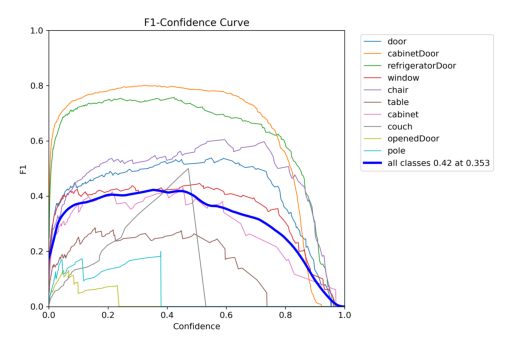



/content/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


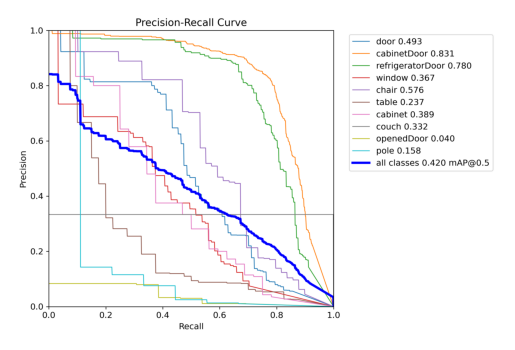



/content/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


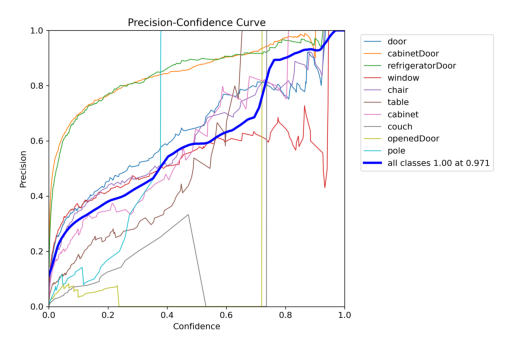



/content/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


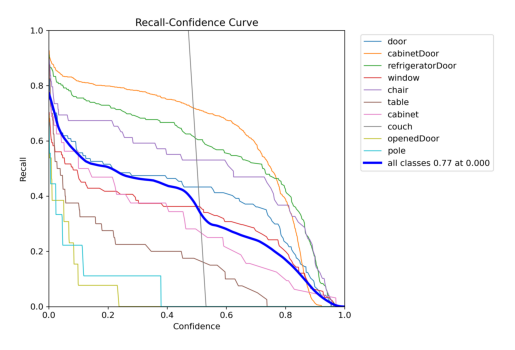



/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


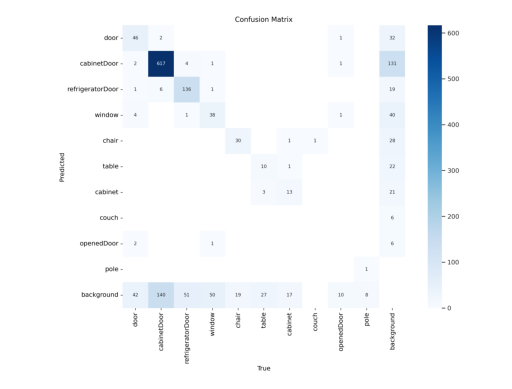



/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


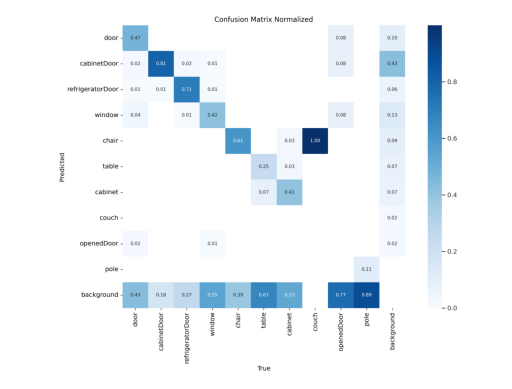



/content/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


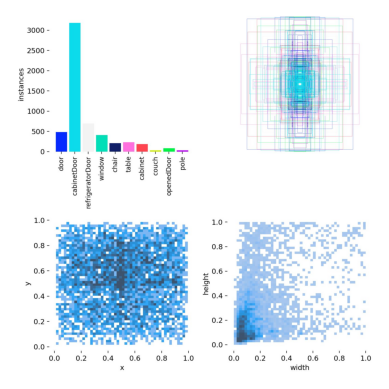



/content/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


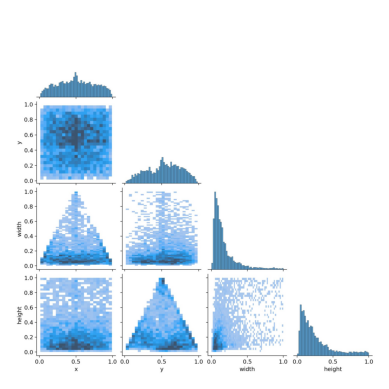



/content/runs/detect/yolov9e_ppe_css_70_epochs/results.png


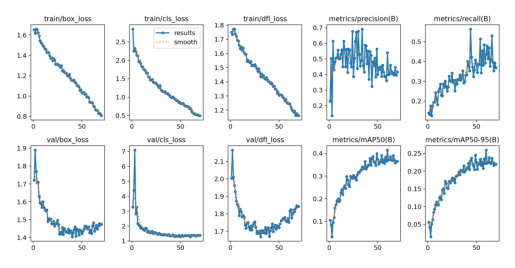

In [42]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [43]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,130.182,1.65185,2.85090,1.74961,0.22941,0.14048,0.10514,0.05611,1.72116,3.26755,2.00281,0.000236,0.000236,0.000236
1,2,200.506,1.61774,2.25036,1.73271,0.50301,0.13169,0.08381,0.04187,1.88939,4.39658,2.16477,0.000467,0.000467,0.000467
2,3,269.588,1.65878,2.32605,1.77216,0.13555,0.17613,0.03260,0.01493,1.76965,7.09313,2.01002,0.000692,0.000692,0.000692
3,4,338.131,1.65563,2.23889,1.77179,0.61399,0.12616,0.09496,0.05049,1.70748,2.81878,1.96279,0.000684,0.000684,0.000684
4,5,407.008,1.62406,2.15173,1.73818,0.43057,0.17568,0.11748,0.06330,1.70950,3.26735,1.92706,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,4582.950,0.85868,0.52504,1.19321,0.40916,0.52955,0.39086,0.23595,1.44693,1.33524,1.81342,0.000058,0.000058,0.000058
66,67,4651.060,0.83027,0.51676,1.16232,0.39765,0.39646,0.37154,0.22497,1.46407,1.36658,1.83050,0.000048,0.000048,0.000048
67,68,4719.100,0.83275,0.51862,1.17676,0.44642,0.35328,0.35739,0.21590,1.47831,1.39104,1.84644,0.000037,0.000037,0.000037
68,69,4787.200,0.82268,0.50334,1.16504,0.39633,0.39184,0.36507,0.22148,1.46974,1.36990,1.83985,0.000027,0.000027,0.000027


In [44]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.80766 , on epoch:  70 


Best Validation Box loss:  1.40422 , on epoch:  40 


Best Training Cls loss:  0.49461 , on epoch:  70 


Best Validation Cls loss:  1.28259 , on epoch:  60 


Best Training DFL loss:  1.16066 , on epoch:  70 


Best Validation DFL loss:  1.66842 , on epoch:  31 



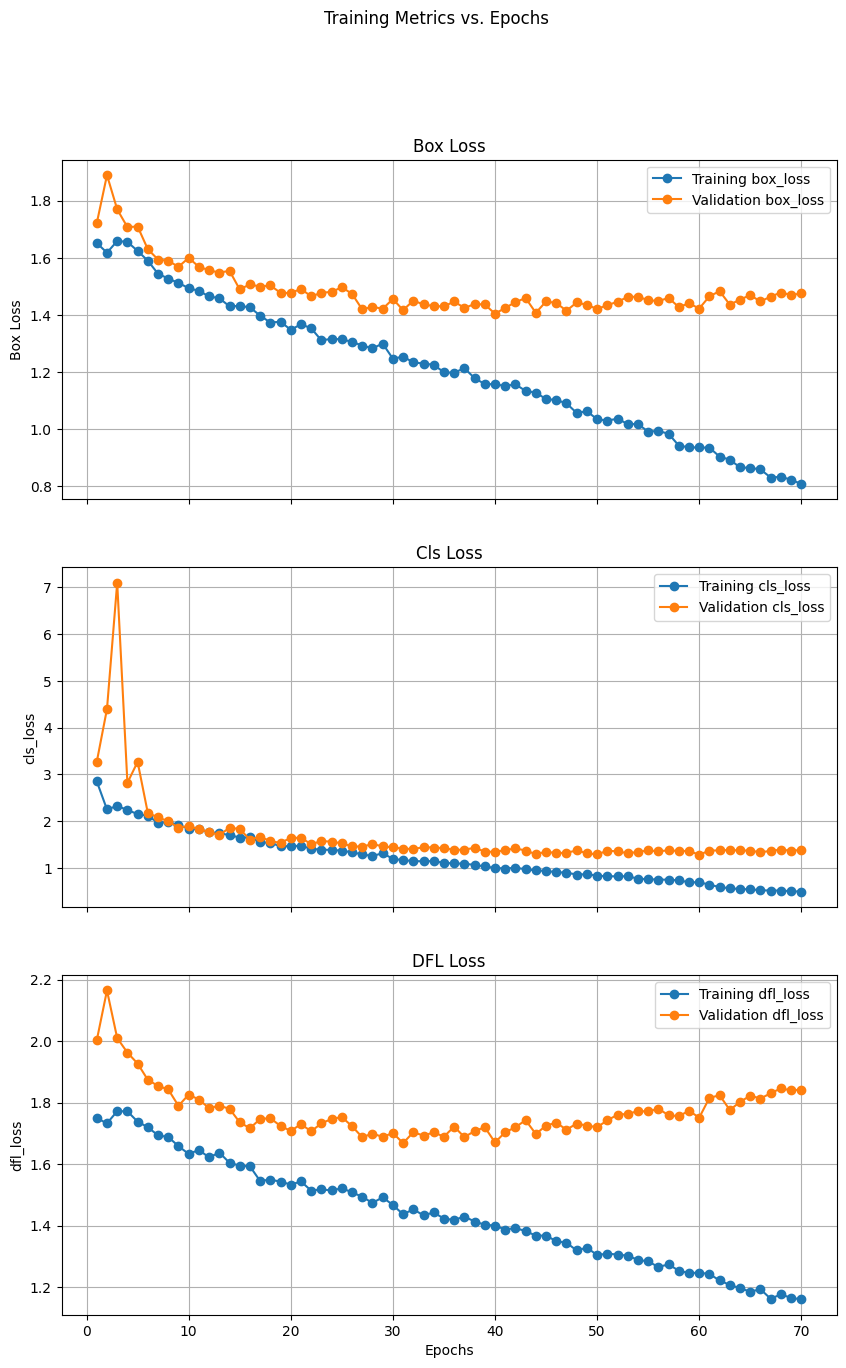

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [46]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [47]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/content/runs/detect/yolov9e_ppe_css_70_epochs/val_batch0_labels.jpg


/content/runs/detect/yolov9e_ppe_css_70_epochs/val_batch0_labels.jpg


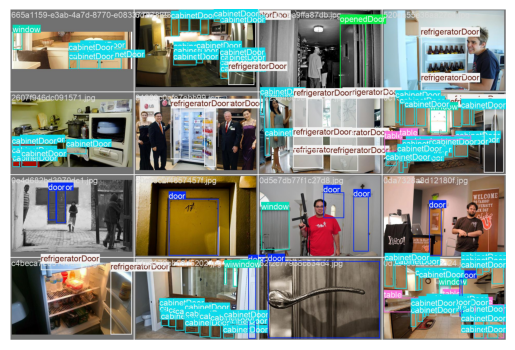

In [48]:

### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

## Висновки



1.   Згідно з графіками модель була перенавчена. Достатньо було близхько 20-30 епох.
2.   Для збереження якості зображень застосовувалась A100 через високі вимоги до оперативної пам'яті, тренування тривало близько 1,3 годин.
3. Через асиметрію класів, найкраще модель навчилась розпізнавати дверцята шаф (F1 - 0.83) найгірше стовпи (F1 - 0.18).
4. Подальші кроки:
  1. тестування на більш дешевих варіантах моделей з ресайзом зображень до 640х480
  2. використання меншої кількості епох
  3. додання зупинки з толерантністю до 2-3 епох
  4. балансування датасету за рахунок аугментації



In [53]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [54]:
!cp -r '/content/runs/.' '/content/drive/MyDrive/YOLO_weights_lesson8/runs'

In [55]:
#!cp -r '/content/runs/.' '/content/drive/MyDrive/YOLO_weights_lesson8/runs'

!cp -r '/content/sample_data/.' '/content/drive/MyDrive/YOLO_weights_lesson8/sample_data'
!cp -r '/content/test/.' '/content/drive/MyDrive/YOLO_weights_lesson8/test'
!cp -r '/content/train/.' '/content/drive/MyDrive/YOLO_weights_lesson8/train'
!cp -r '/content/valid/.' '/content/drive/MyDrive/YOLO_weights_lesson8/valid'
!cp -r '/content/wandb/.' '/content/drive/MyDrive/YOLO_weights_lesson8/wandb'
!cp -r '/content/data.yaml' '/content/drive/MyDrive/YOLO_weights_lesson8/data.yaml'
!cp -r '/content/training_log_df.csv' '/content/drive/MyDrive/YOLO_weights_lesson8/training_log_df.csv'
!cp -r '/content/yolo11n.pt' '/content/drive/MyDrive/YOLO_weights_lesson8/yolo11n.pt'
!cp -r '/content/yolov9e.pt' '/content/drive/MyDrive/YOLO_weights_lesson8/yolov9e.pt'

In [57]:
!zip -r yolo-test.zip ./ -x "drive/*"

	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Screenshot_20200409-033855__01 (2).jpg
	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Screenshot_20200409-033855__01 (1).jpg
	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Screenshot_20200409-033845__01 (1).jpg
	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Screenshot_20200409-033855__01.jpg
	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Aprajita Dey - Case review task.gsheet
	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Screenshot_20200409-033850__01 (1).jpg
	zip warning: name not matched: ./drive/MyDrive/Classroom/Radiology 3year ONMedU (1)/Case review task/Screenshot_20200409-033850__01.jpg
	zip warning: name no

In [58]:
from google.colab import files
files.download('yolo-test.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
!cp -r '/content/yolo-test.zip' '/content/drive/MyDrive/YOLO_weights_lesson8/yolo-test.zip'